In [1]:
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import matplotlib.pyplot as plt

In [2]:
from pyspark.ml.linalg import Vectors
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession
from pyspark.ml.feature import HashingTF, IDF, Tokenizer

In [3]:
spark = SparkSession.builder.appName('Project').getOrCreate()

dataset=spark.read.csv("reviews.tbl", inferSchema = True, header = True, sep = '|')

dataset.createTempView("product_reviews")

In [4]:
q="SELECT CASE pr_rating WHEN 1 THEN '0' WHEN 2 THEN '0' WHEN 3 THEN '0' WHEN 4 THEN '1' WHEN 5 THEN '1' END AS pr_r_rating, pr_content FROM product_reviews WHERE pmod(pr_review_id, 5) IN (1,2,3)"

In [5]:
df = spark.sql(q).toDF("label", "sentence")

In [6]:
tokenizer = Tokenizer(inputCol="sentence", outputCol="words")
wordsData = tokenizer.transform(df)

In [7]:
hashingTF = HashingTF(inputCol="words",outputCol="rawFeatures")

In [8]:
featurizedData = hashingTF.transform(wordsData)

In [9]:
idf = IDF(inputCol = "rawFeatures",outputCol = "features")

In [10]:
idfModel = idf.fit(featurizedData)

In [11]:
rescaledData = idfModel.transform(featurizedData)

In [12]:
rescaledData.select("label", "sentence").show()

+-----+--------------------+
|label|            sentence|
+-----+--------------------+
|    0|attainments are; ...|
|    0|fluffily ironic e...|
|    0|dolphins about ov...|
|    0|bullshit must sub...|
|    0|silent decline or...|
|    0|bold platelets ex...|
|    0|special sustainab...|
|    1|quick winner afte...|
|    0|frays doze whitho...|
|    0|dolphins in place...|
|    0|bravely permanent...|
|    1|ruthlessly risk-f...|
|    0|best-performing d...|
|    0|orbits need to in...|
|    0|idle patience cou...|
|    0|busy deny tithes ...|
|    0|quick brave notor...|
|    0|sheaves will have...|
|    0|daringly fluffy f...|
|    0|carefully express...|
+-----+--------------------+
only showing top 20 rows



In [13]:
rescaledData.printSchema()

root
 |-- label: string (nullable = true)
 |-- sentence: string (nullable = true)
 |-- words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- rawFeatures: vector (nullable = true)
 |-- features: vector (nullable = true)



In [14]:
df = rescaledData.select(rescaledData["label"].cast("double"),(rescaledData["features"]))

In [15]:
df.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|(262144,[12925,50...|
|  0.0|(262144,[61231,68...|
|  0.0|(262144,[10300,18...|
|  0.0|(262144,[11209,70...|
|  0.0|(262144,[20779,27...|
|  0.0|(262144,[5987,612...|
|  0.0|(262144,[25416,25...|
|  1.0|(262144,[12925,22...|
|  0.0|(262144,[18375,21...|
|  0.0|(262144,[9639,183...|
|  0.0|(262144,[18391,28...|
|  1.0|(262144,[25416,11...|
|  0.0|(262144,[6504,104...|
|  0.0|(262144,[20497,20...|
|  0.0|(262144,[40140,10...|
|  0.0|(262144,[329,1292...|
|  0.0|(262144,[9639,223...|
|  0.0|(262144,[329,2813...|
|  0.0|(262144,[21683,37...|
|  0.0|(262144,[329,1540...|
+-----+--------------------+
only showing top 20 rows



In [16]:
training, test = df.randomSplit([0.6, 0.4])

In [17]:
nb = NaiveBayes(smoothing=1.0, modelType='multinomial')

In [18]:
model = nb.fit(training)

In [19]:
predictions = model.transform(test)

In [29]:
train = model.transform(training)

In [30]:
train.show()

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|  0.0|(262144,[11,64,86...|[-586.60933259393...|[1.0,5.7658715697...|       0.0|
|  0.0|(262144,[11,64,12...|[-220.53348690324...|[0.99999999999986...|       0.0|
|  0.0|(262144,[11,170,2...|[-337.16161073431...|[1.0,1.4265250020...|       0.0|
|  0.0|(262144,[11,170,2...|[-185.02134438173...|[0.99999999999995...|       0.0|
|  0.0|(262144,[11,329,4...|[-664.06034611989...|[1.0,3.3195980297...|       0.0|
|  0.0|(262144,[11,329,7...|[-854.41098095319...|[1.0,3.1200993010...|       0.0|
|  0.0|(262144,[11,329,9...|[-453.82734577806...|[1.0,3.0418276823...|       0.0|
|  0.0|(262144,[11,329,1...|[-771.34460196091...|[1.0,3.7932128501...|       0.0|
|  0.0|(262144,[11,329,1...|[-563.29730610406...|[1.0,6.7729930323...|       0.0|
|  0.0|(262144,[

In [20]:
predictions.show()

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|  0.0|(262144,[11,64,86...|[-896.25192237073...|[1.0,3.7781682606...|       0.0|
|  0.0|(262144,[11,329,2...|[-879.87038612051...|[1.0,2.6387948383...|       0.0|
|  0.0|(262144,[11,329,4...|[-773.23675053775...|[1.0,1.7502229240...|       0.0|
|  0.0|(262144,[11,329,8...|[-674.60666343552...|[1.0,2.3106121396...|       0.0|
|  0.0|(262144,[11,329,9...|[-428.80394326029...|[1.0,3.5079201376...|       0.0|
|  0.0|(262144,[11,329,1...|[-354.31949874693...|[1.0,2.0947133839...|       0.0|
|  0.0|(262144,[11,329,1...|[-1094.1844266744...|[1.0,1.4146219274...|       0.0|
|  0.0|(262144,[11,685,4...|[-870.89704280721...|[1.0,3.7346869078...|       0.0|
|  0.0|(262144,[11,2150,...|[-380.59674089745...|[1.0,1.9363746108...|       0.0|
|  0.0|(262144,[

In [21]:
evaluator = MulticlassClassificationEvaluator(labelCol="label",predictionCol="prediction",metricName="accuracy")

In [22]:
accuracy=evaluator.evaluate(predictions)

In [23]:
print ("Test set accuracy = "+ str(accuracy))


Test set accuracy = 0.8715830273357813


In [24]:

fig=plt.figure()

<Figure size 432x288 with 0 Axes>

In [25]:
ax=fig.add_subplot(111)

In [28]:
import numpy as np
X=np.array(predictions)

In [31]:
Y=np.array(train)

In [34]:
print(X)

DataFrame[label: double, features: vector, rawPrediction: vector, probability: vector, prediction: double]


In [69]:
plot_x= predictions.select("prediction")

In [91]:
plot_y=train.select("prediction")

In [75]:
import pandas as pd

In [104]:
y=plot_y.toPandas()

In [111]:
print(y)

       prediction
0             0.0
1             0.0
2             0.0
3             0.0
4             0.0
...           ...
14537         1.0
14538         0.0
14539         0.0
14540         0.0
14541         0.0

[14542 rows x 1 columns]


In [77]:
x= plot_x.toPandas()

([array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0.

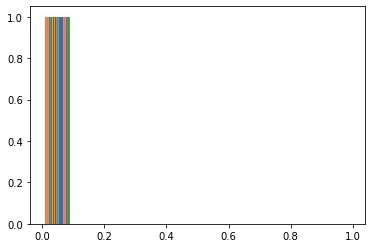

In [93]:
plt.hist(y)

(array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 array([0.37158303, 0.47158303, 0.57158303, 0.67158303, 0.77158303,
        0.87158303, 0.97158303, 1.07158303, 1.17158303, 1.27158303,
        1.37158303]),
 <a list of 10 Patch objects>)

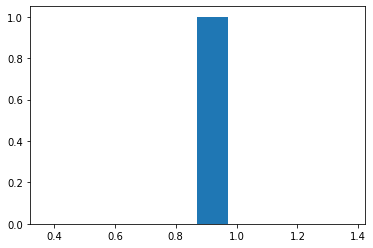

In [101]:
plt.hist(accuracy)

In [120]:
import numpy as np
n=3
x,y=np.arange(1,n)

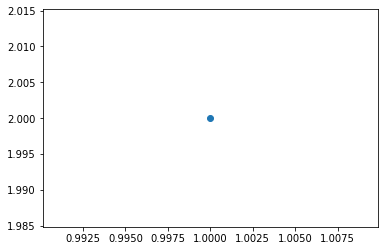

In [121]:
plt.scatter(x,y)